In [8]:
# Cell 1: imports
import math
import numpy as np
import random
from copy import deepcopy

In [9]:
#cell 2: connect 4 definitions and minimax agent
class Connect4:
    def __init__(self, rows=6, cols=7, connect=4):
        self.rows = rows
        self.cols = cols
        self.connect = connect
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1  # 1 = X, -1 = O
        self.last_move = None
        self.done = False
        self.winner = None
        return self.board.copy()

    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if action not in self.valid_actions():
            raise ValueError("Invalid action")

        # drop piece
        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        winner = check_winner(self.board, self.connect, self.last_move)
        if winner is not None:
            self.done = True
            self.winner = winner
            reward = 1 if winner == self.current_player else -1
        elif np.all(self.board != 0):
            self.done = True
            self.winner = 0
            reward = 0
        else:
            reward = 0

        if not self.done:
            self.current_player *= -1

        return self.board.copy(), reward, self.done, {}

    def render(self):
        sym = {1: 'X', -1: 'O', 0: '.'}
        for r in range(self.rows):
            print(" ".join(sym[int(x)] for x in self.board[r]))
        print(" ".join(str(i) for i in range(self.cols)))
        print()

def check_winner(board, connect=4, last_move=None):
    rows, cols = board.shape

    if last_move is not None:
        r0, c0 = last_move
        player = board[r0, c0]
        if player == 0:
            return None

        dirs = [(1,0), (0,1), (1,1), (-1,1)]
        for dr, dc in dirs:
            count = 1

            rr, cc = r0 + dr, c0 + dc
            while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                count += 1
                rr += dr; cc += dc

            rr, cc = r0 - dr, c0 - dc
            while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                count += 1
                rr -= dr; cc -= dc

            if count >= connect:
                return player

        return None

    for r in range(rows):
        for c in range(cols):
            if board[r,c] == 0:
                continue
            player = board[r,c]
            for dr, dc in [(1,0),(0,1),(1,1),(-1,1)]:
                cnt = 0
                rr, cc = r, c
                while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                    cnt += 1
                    rr += dr; cc += dc
                if cnt >= connect:
                    return player
    return None

def heuristic_evaluate(board, player):
    rows, cols = board.shape
    opponent = -player

    SCORE = {4: 100000, 3: 100, 2: 10}
    total = 0

    def score_window(window):
        s = 0
        cnt_p = np.count_nonzero(window == player)
        cnt_o = np.count_nonzero(window == opponent)
        cnt_e = np.count_nonzero(window == 0)

        if cnt_p == 4:
            s += SCORE[4]
        elif cnt_p == 3 and cnt_e == 1:
            s += SCORE[3]
        elif cnt_p == 2 and cnt_e == 2:
            s += SCORE[2]

        if cnt_o == 4:
            s -= SCORE[4]
        elif cnt_o == 3 and cnt_e == 1:
            s -= SCORE[3]*0.9
        elif cnt_o == 2 and cnt_e == 2:
            s -= SCORE[2]*0.5

        return s

    # horizontal
    for r in range(rows):
        for c in range(cols-3):
            window = board[r, c:c+4]
            total += score_window(window)

    # vertical
    for c in range(cols):
        for r in range(rows-3):
            window = board[r:r+4, c]
            total += score_window(window)

    # diag down-right
    for r in range(rows-3):
        for c in range(cols-3):
            window = np.array([board[r+i, c+i] for i in range(4)])
            total += score_window(window)

    # diag up-right
    for r in range(3, rows):
        for c in range(cols-3):
            window = np.array([board[r-i, c+i] for i in range(4)])
            total += score_window(window)

    # center column preference
    center = cols // 2
    total += np.count_nonzero(board[:, center] == player) * 3

    return total

def minimax_ab(board, depth, alpha, beta, maximizing, player_to_move, env):
    w = check_winner(board, env.connect, last_move=None)
    if w is not None:
        return (1e9 if w == 1 else -1e9), None
    if np.all(board != 0):
        return 0, None
    if depth == 0:
        return heuristic_evaluate(board, player_to_move), None

    valid_moves = [c for c in range(env.cols) if board[0, c] == 0]
    valid_moves.sort(key=lambda c: -abs(c - env.cols//2))  # center-first move ordering

    best_move = None

    if maximizing:
        value = -math.inf
        for col in valid_moves:
            new_board = board.copy()
            for r in range(env.rows-1, -1, -1):
                if new_board[r, col] == 0:
                    new_board[r, col] = player_to_move
                    last_r = r
                    break

            w = check_winner(new_board, env.connect, last_move=(last_r, col))
            if w is not None:
                v = 1e9
            else:
                v, _ = minimax_ab(new_board, depth-1, alpha, beta, False, -player_to_move, env)

            if v > value:
                value = v
                best_move = col

            alpha = max(alpha, value)
            if alpha >= beta:
                break

        return value, best_move

    else:
        value = math.inf
        for col in valid_moves:
            new_board = board.copy()
            for r in range(env.rows-1, -1, -1):
                if new_board[r, col] == 0:
                    new_board[r, col] = player_to_move
                    last_r = r
                    break

            w = check_winner(new_board, env.connect, last_move=(last_r, col))
            if w is not None:
                v = -1e9
            else:
                v, _ = minimax_ab(new_board, depth-1, alpha, beta, True, -player_to_move, env)

            if v < value:
                value = v
                best_move = col

            beta = min(beta, value)
            if alpha >= beta:
                break

        return value, best_move
    
def minimax_agent(env, depth=4):
    board = env.board.copy()
    player = env.current_player
    value, action = minimax_ab(board, depth, -math.inf, math.inf, True, player, env)
    if action is None:
        return random.choice(env.valid_actions())
    return action


In [ ]:
#Cell 3: game loop human vs AI(minimax)
env = Connect4()
game_over = False

print("Starting Connect Four")
env.render()

# 0 = Human, 1 = AI
turn = 0

while not game_over:

    if turn == 0:
        # Human move
        valid = env.valid_actions()
        col = None
        while col not in valid:
            try:
                col_input = int(input(f"Your move {valid}: "))
                if col_input in valid:
                    col = col_input
                else:
                    print("Invalid column. Choose from", valid)
            except:
                print("Enter a valid integer column.")
        
        _, _, game_over, _ = env.step(col)

        if env.winner == 1:
            env.render()
            print("You win!")
            break

    else:
        # AI move using minimax
        print("AI thinking...")
        col = minimax_agent(env, depth=4)
        _, _, game_over, _ = env.step(col)

        if env.winner == -1:
            env.render()
            print("AI wins!")
            break

    env.render()
    turn = 1 - turn  # switch turns

    # Check draw
    if game_over and env.winner == 0:
        print("Draw!")
        break

Starting Connect Four
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . . . . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . . O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . O O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
X . O O . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
O . . X . . .
X . O O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .

In [ ]:


import numpy as np
import random
import time
from collections import defaultdict

q_table = defaultdict(lambda: np.zeros(7, dtype=float))

alpha = 0.25
gamma = 0.99

epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 50000

total_episodes = 50000    # full curriculum length
min_episodes = 20000

curriculum = [
    ("random", 0.25),     # 25% vs random
    ("minimax2", 0.35),   # 35% vs minimax depth 2
    ("selfplay", 0.40)    # final 40% self-play
]


def extract_features(board, player):
    opp = -player
    rows, cols = board.shape

    def count_patterns(val, length):
        cnt = 0

        # horizontal
        for r in range(rows):
            for c in range(cols - 3):
                w = list(board[r, c:c+4])
                if w.count(val) == length and w.count(0) == (4 - length):
                    cnt += 1

        # vertical
        for c in range(cols):
            for r in range(rows - 3):
                w = list(board[r:r+4, c])
                if w.count(val) == length and w.count(0) == (4 - length):
                    cnt += 1

        # diag down-right
        for r in range(rows - 3):
            for c in range(cols - 3):
                w = [board[r+i, c+i] for i in range(4)]
                if w.count(val) == length and w.count(0) == (4 - length):
                    cnt += 1

        # diag up-right
        for r in range(3, rows):
            for c in range(cols - 3):
                w = [board[r-i, c+i] for i in range(4)]
                if w.count(val) == length and w.count(0) == (4 - length):
                    cnt += 1

        return cnt

    p2 = min(count_patterns(player, 2), 4)
    p3 = min(count_patterns(player, 3), 4)
    o2 = min(count_patterns(opp, 2), 4)
    o3 = min(count_patterns(opp, 3), 4)

    center_col = cols // 2
    center_ctrl = int(np.count_nonzero(board[:, center_col] == player))

    valid = [1 if board[0, c] == 0 else 0 for c in range(cols)]
    mask_thirds = (sum(valid[0:3]) > 0) * 1 + (sum(valid[2:5]) > 0) * 2 + (sum(valid[4:7]) > 0) * 4

    return (p2, p3, o2, o3, min(center_ctrl, 6), mask_thirds)

def state_key(board, player):
    return (extract_features(board, player), player)

def shaped_reward(board, player, base_reward):
    p2, p3, o2, o3, center, _ = extract_features(board, player)

    r = 0
    r += 0.08 * p2
    r += 0.35 * p3
    r -= 0.08 * o2
    r -= 0.6 * o3
    r += 0.03 * center

    return r + base_reward


def choose_action(state_key, valid, epsilon):
    if random.random() < epsilon:
        # exploration but biased toward center
        if random.random() < 0.7:
            center = 3
            return sorted(valid, key=lambda c: abs(c - center))[0]
        return random.choice(valid)

    q_vals = q_table[state_key]
    masked = np.full_like(q_vals, -np.inf)
    masked[valid] = q_vals[valid]
    return int(np.argmax(masked))

def evaluate_vs_minimax(depth=2, n_games=50):
    wins = losses = draws = 0

    for _ in range(n_games):
        env = Connect4()
        turn = random.choice([1, -1])
        env.current_player = turn
        done = False

        while not done:
            if env.current_player == 1:
                col = q_agent(env)
            else:
                col = minimax_agent(env, depth=depth)

            _, _, done, _ = env.step(col)

        if env.winner == 1:
            wins += 1
        elif env.winner == -1:
            losses += 1
        else:
            draws += 1

    return wins, losses, draws

def train_q_agent(num_episodes=total_episodes, verbose=True):
    schedule = []
    for name, frac in curriculum:
        count = int(frac * num_episodes)
        schedule.extend([name] * count)
    while len(schedule) < num_episodes:
        schedule.append("selfplay")

    epsilon = epsilon_start
    eps_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps

    for ep in range(num_episodes):
        mode = schedule[ep]

        env = Connect4()
        s_key = state_key(env.board, env.current_player)
        done = False

        while not done:
            valid = env.valid_actions()

            if env.current_player == 1:
                action = choose_action(s_key, valid, epsilon)
                board2, base_reward, done, _ = env.step(action)
                shaped = shaped_reward(board2, -env.current_player, base_reward)

                next_key = state_key(board2, env.current_player)
                q_vals = q_table[s_key]
                next_q = q_table[next_key]

                target = shaped
                if not done:
                    target += gamma * np.max(next_q)

                q_vals[action] += alpha * (target - q_vals[action])
                s_key = next_key


            else:
                if mode == "random":
                    opp = random.choice(valid)
                elif mode == "minimax2":
                    opp = minimax_agent(env, depth=2)
                else:  # selfplay: opponent tries greedy
                    qvals = q_table[state_key(env.board, env.current_player)]
                    masked = np.full_like(qvals, -np.inf)
                    valid2 = env.valid_actions()
                    masked[valid2] = qvals[valid2]
                    opp = int(np.argmax(masked))

                _, _, done, _ = env.step(opp)
                s_key = state_key(env.board, env.current_player)

        # Decay epsilon
        if ep < epsilon_decay_steps:
            epsilon = max(epsilon_end, epsilon - eps_decay)
        else:
            epsilon = epsilon_end

        # Progress print
        if verbose and ep % 2500 == 0 and ep > 0:
            w, l, d = evaluate_vs_minimax(depth=2, n_games=20)
            print(f"Episode {ep}/{num_episodes} | eps={epsilon:.3f} | vs minimax2 (20 games): W {w} / L {l} / D {d}")

    print("Training complete.")
    return q_table


def q_agent(env):
    s_key = state_key(env.board, env.current_player)
    q_vals = q_table[s_key]
    valid = env.valid_actions()

    masked = np.full_like(q_vals, -np.inf)
    masked[valid] = q_vals[valid]

    best = np.flatnonzero(masked == masked.max())
    best = sorted(best, key=lambda c: abs(c - 3))
    return int(best[0])


print("Starting Q-agent training…")
train_q_agent()
print("Q-agent ready.")

Starting Q-agent training…
Episode 2500/50000 | eps=0.952 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 5000/50000 | eps=0.905 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 7500/50000 | eps=0.857 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 10000/50000 | eps=0.810 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 12500/50000 | eps=0.762 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 15000/50000 | eps=0.715 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 17500/50000 | eps=0.667 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 20000/50000 | eps=0.620 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 22500/50000 | eps=0.572 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 25000/50000 | eps=0.525 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 27500/50000 | eps=0.477 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 30000/50000 | eps=0.430 | vs minimax2 (20 games): W 0 / L 20 / D 0
Episode 32500/50000 | eps=0.382 | vs minimax2 (20 games): W 0 / L 20 / D 0
E

In [13]:
#Cell 5: game loop human vs Ai(q-learning)
env = Connect4()
game_over = False
turn = 0  # 0 = human, 1 = Q-learning AI

print("Play against Q-learning AI")
env.render()

while not game_over:
    if turn == 0:
        # Human move
        valid = env.valid_actions()
        col = None
        while col not in valid:
            try:
                col_input = int(input(f"Your move {valid}: "))
                if col_input in valid:
                    col = col_input
            except:
                pass
        _, _, game_over, _ = env.step(col)

    else:
        # Q-learning AI move
        col = q_agent(env)
        _, _, game_over, _ = env.step(col)

    env.render()
    turn = 1 - turn

    if game_over:
        if env.winner == 1:
            print("Human wins!")
        elif env.winner == -1:
            print("AI wins!")
        else:
            print("Draw!")

Play against Q-learning AI
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . O . . .
. . X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . O . . .
. X X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . O . . .
. . . O . . .
. . . O . . .
. X X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . O . . .
. . . O . . .
. . . O . . .
X X X X . . .
0 1 2 3 4 5 6

Human wins!


In [ ]:
#cell 6: minimax vs q-learning
num_simulations = 1  # number of games to simulate
ai1_wins = 0
ai2_wins = 0
draws = 0

# Optional: you can replace ai1_action and ai2_action with minimax_agent if you want a comparison
for sim in range(num_simulations):
    env = Connect4()
    game_over = False
    turn = 0  # 0 = Q-learning AI (ai1), 1 = Q-learning AI (ai2)

    while not game_over:
        if turn == 0:
            col = minimax_agent(env)
            _, _, game_over, _ = env.step(col)
        else:
            col = q_agent(env)
            _, _, game_over, _ = env.step(col)

        turn = 1 - turn

    if env.winner == 1:
        ai1_wins += 1
    elif env.winner == -1:
        ai2_wins += 1
    else:
        draws += 1

print(f"After {num_simulations} games:")
print(f"AI1 wins: {ai1_wins} ({ai1_wins/num_simulations*100:.1f}%)")
print(f"AI2 wins: {ai2_wins} ({ai2_wins/num_simulations*100:.1f}%)")
print(f"Draws   : {draws} ({draws/num_simulations*100:.1f}%)")

After 1 games:
AI1 wins: 1 (100.0%)
AI2 wins: 0 (0.0%)
Draws   : 0 (0.0%)


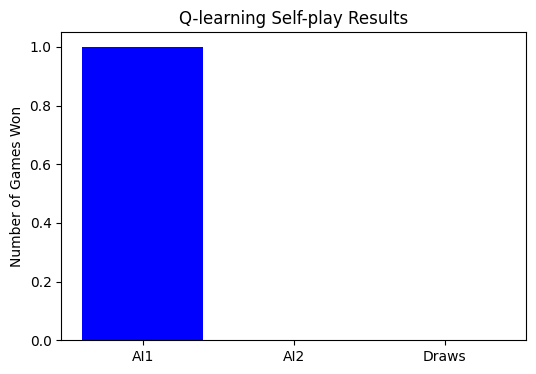

In [ ]:
#cell 7: plot
import matplotlib.pyplot as plt

labels = ['AI1', 'AI2', 'Draws']
counts = [ai1_wins, ai2_wins, draws]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['blue','red','gray'])
plt.title('Q-learning Self-play Results')
plt.ylabel('Number of Games Won')
plt.show()